In [52]:
# 1. Imports
import numpy as np
import torch
import glob
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
from torchvision import models
from torchvision.transforms.functional import to_pil_image


In [53]:
# 2. Dataset class
class MRI(Dataset):
    def __init__(self):
        tumor, healthy = [], []

        for f in glob.iglob("data/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.transpose(2, 0, 1).astype(np.float32)
            tumor.append(img)

        for f in glob.iglob("data/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img, (128, 128))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = img.transpose(2, 0, 1).astype(np.float32)
            healthy.append(img)

        self.images = np.concatenate((healthy, tumor), axis=0)
        self.labels = np.concatenate((
            np.zeros(len(healthy), dtype=np.float32),
            np.ones(len(tumor), dtype=np.float32)
        ))

        self.normalize()
        self.train_val_split()

    def normalize(self):
        self.images = self.images / 255.0

    def train_val_split(self):
        self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
            self.images, self.labels, test_size=0.2, random_state=42
        )

    def set_mode(self, mode):
        self.mode = mode

    def __len__(self):
        return len(self.x_train) if self.mode == 'train' else len(self.x_val)

    def __getitem__(self, idx):
        if self.mode == 'train':
            return {'image': self.x_train[idx], 'label': self.y_train[idx]}
        else:
            return {'image': self.x_val[idx], 'label': self.y_val[idx]}


In [54]:
# 3. Plotting function
def plot_random(healthy, tumor, num=5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace=False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace=False)]

    plt.figure(figsize=(16, 5))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(healthy_imgs[i].astype(np.uint8))
        plt.title("Healthy")
        plt.axis("off")

    plt.figure(figsize=(16, 5))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.imshow(tumor_imgs[i].astype(np.uint8))
        plt.title("Tumor")
        plt.axis("off")


In [55]:
class TumorResNet(nn.Module):
    def __init__(self, pretrained=True, freeze_backbone=False):
        super().__init__()
        self.backbone = models.resnet101(
            weights=models.ResNet101_Weights.IMAGENET1K_V1 if pretrained else None
        )

        if freeze_backbone:
            for name, param in self.backbone.named_parameters():
                if "layer4" not in name and "fc" not in name:
                    param.requires_grad = False

        in_feats = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(in_feats, 1)   # raw logit for BCEWithLogitsLoss

    def forward(self, x):
        return self.backbone(x)   # logi

In [ ]:
# 5. Training with Early‑Stopping + L2 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


train_base = MRI();  train_base.set_mode('train')
val_base   = MRI();  val_base.set_mode('val')


IMNET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
IMNET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

class ToTensorNorm(torch.utils.data.Dataset):
    def __init__(self, base):
        self.base = base
    def __len__(self): return len(self.base)
    def __getitem__(self, idx):
        sample = self.base[idx]
        img = torch.tensor(sample['image'])          
        img = (img - IMNET_MEAN) / IMNET_STD         
        label = torch.tensor(sample['label'])
        return {'image': img, 'label': label}

train_ds = ToTensorNorm(train_base)
val_ds   = ToTensorNorm(val_base)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False)


model = TumorResNet(pretrained=True, freeze_backbone=False).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion  = nn.BCEWithLogitsLoss()


best_val = float('inf')
best_state = None
patience = 15
stale_epochs = 0

epochs = 100
train_hist, val_hist = [], []

for ep in range(epochs):
    
    model.train(); train_loss = 0
    for batch in train_loader:
        img = batch['image'].to(device)
        lbl = batch['label'].float().to(device).unsqueeze(1)

        optimizer.zero_grad()
        logit = model(img)
        loss = criterion(logit, lbl)
        loss.backward(); optimizer.step()
        train_loss += loss.item() * img.size(0)
    train_loss /= len(train_ds)
    train_hist.append(train_loss)

    
    model.eval(); val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            img = batch['image'].to(device)
            lbl = batch['label'].float().to(device).unsqueeze(1)
            logit = model(img)
            loss = criterion(logit, lbl)
            val_loss += loss.item() * img.size(0)
    val_loss /= len(val_ds)
    val_hist.append(val_loss)

    
    if (ep+1) % 10 == 0 or ep == 0:
        print(f"Epoch {ep+1}/{epochs}  |  Train {train_loss:.4f}  |  Val {val_loss:.4f}")

    
    if val_loss < best_val:
        best_val = val_loss;  best_state = model.state_dict();  stale_epochs = 0
    else:
        stale_epochs += 1
        if stale_epochs >= patience:
            print(f"\n⏹️  Early‑stopped at epoch {ep+1}.  Best Val Loss = {best_val:.4f}")
            break


model.load_state_dict(best_state)
print("✅  Best model restored.")


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to C:\Users\soham/.cache\torch\hub\checkpoints\resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:24<00:00, 7.41MB/s] 


Epoch 1/100  |  Train 0.5225  |  Val 0.2660
Epoch 10/100  |  Train 0.0428  |  Val 0.3198
Epoch 20/100  |  Train 0.0071  |  Val 0.2549
Epoch 30/100  |  Train 0.0354  |  Val 0.1941
Epoch 40/100  |  Train 0.0110  |  Val 0.0669
Epoch 50/100  |  Train 0.0145  |  Val 0.1537
Epoch 60/100  |  Train 0.0312  |  Val 0.1794

⏹️  Early‑stopped at epoch 60.  Best Val Loss = 0.0487
✅  Best model restored.


Accuracy: 0.9591836734693877


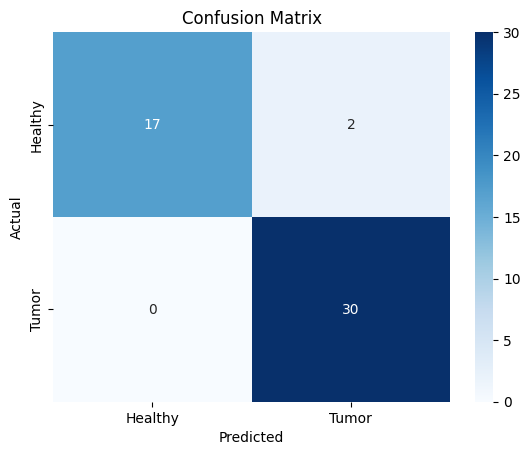

In [ ]:
def threshold(scores, t=0.5):
    return np.where(scores >= t, 1.0, 0.0)

outputs, y_true = [], []

model.eval()
with torch.no_grad():
    for batch in val_loader:                        
        data   = batch['image'].to(device)
        labels = batch['label'].float().to(device)

        logits = model(data)
        probs  = torch.sigmoid(logits)
        preds  = (probs >= 0.5).float()

        outputs.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

outputs = np.array(outputs).squeeze()
y_true  = np.array(y_true).squeeze()

print("Accuracy:", accuracy_score(y_true, outputs))


cm = confusion_matrix(y_true, outputs)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Healthy","Tumor"],
            yticklabels=["Healthy","Tumor"])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

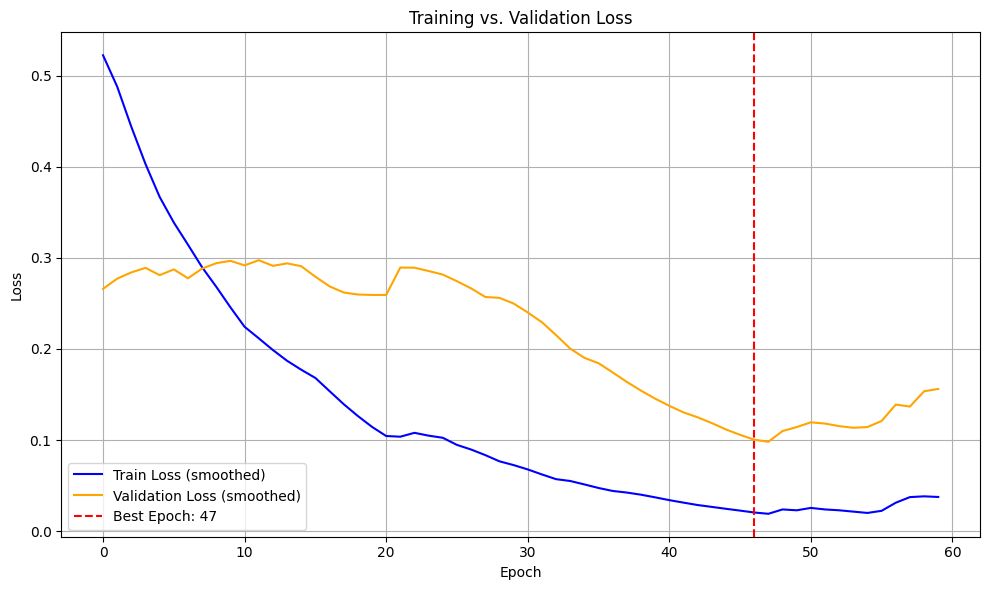

In [ ]:
# 8. Loss Plot

def smooth_curve(points, factor=0.9):
    smoothed = []
    for p in points:
        if smoothed:
            smoothed.append(smoothed[-1] * factor + p * (1 - factor))
        else:
            smoothed.append(p)
    return smoothed

train_smooth = smooth_curve(train_hist)
val_smooth = smooth_curve(val_hist)


best_epoch = np.argmin(train_hist)
best_val = val_hist[best_epoch]

plt.figure(figsize=(10, 6))
plt.plot(train_smooth, label='Train Loss (smoothed)', color='blue')
plt.plot(val_smooth, label='Validation Loss (smoothed)', color='orange')
plt.axvline(best_epoch, color='red', linestyle='--', label=f'Best Epoch: {best_epoch+1}')

plt.title("Training vs. Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Showing 10 predictions from validation set:



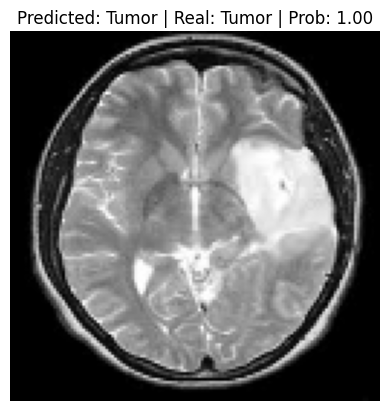

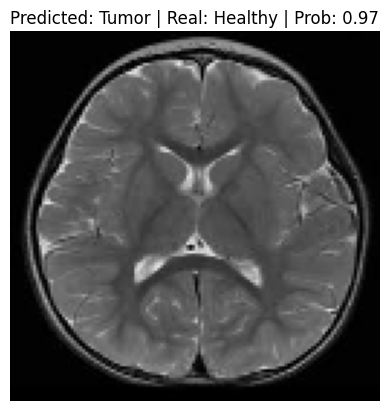

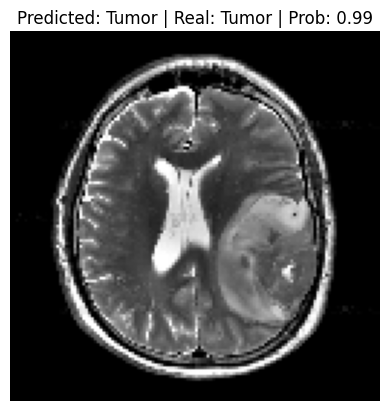

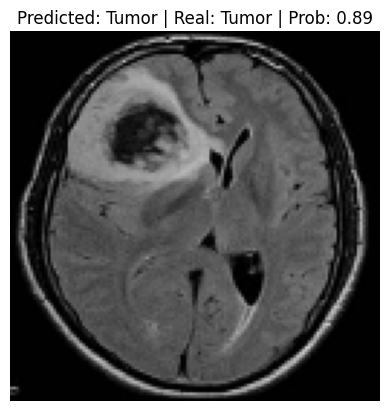

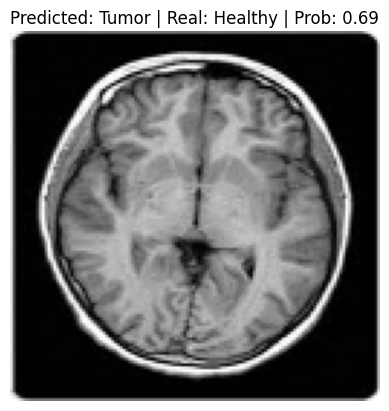

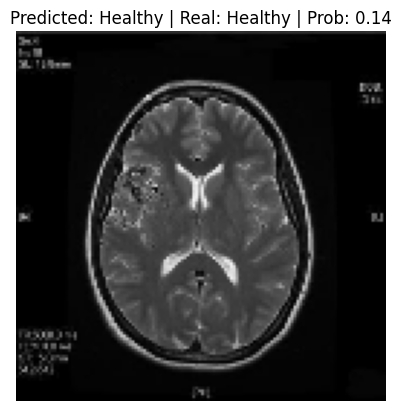

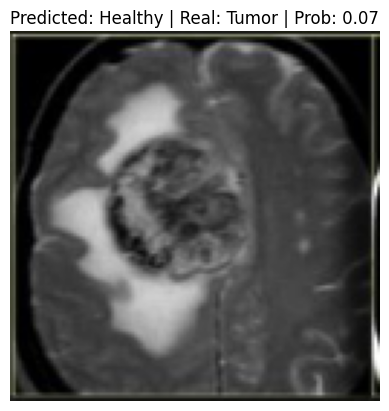

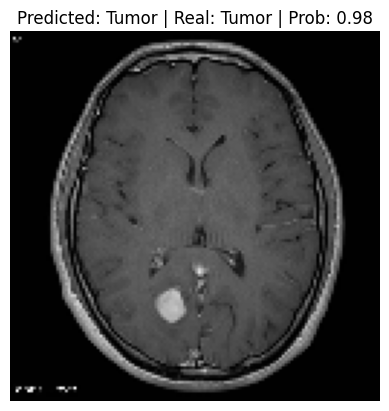

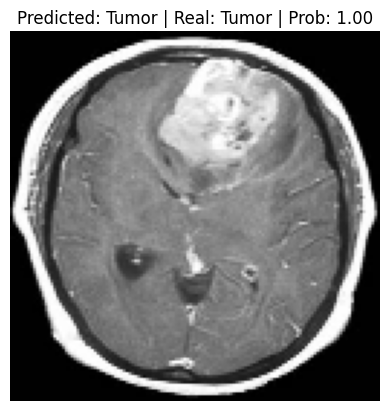

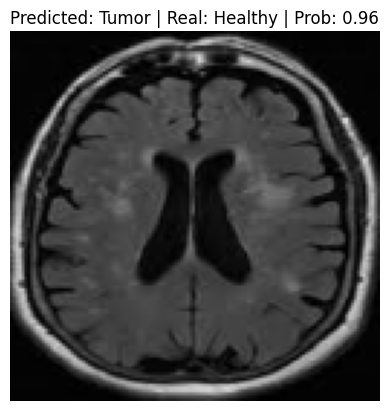

In [ ]:
val_dataset = MRI()
val_dataset.set_mode('val')  
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)

print("Showing 10 predictions from validation set:\n")

count = 0
model.eval()
with torch.no_grad():
    for batch in val_loader:
        image = batch['image'].to(device)
        label = batch['label'].item()

        
        logit = model(image)
        prob = torch.sigmoid(logit).item()
        pred = 1 if prob >= 0.5 else 0

        
        img_np = image.cpu().squeeze().numpy()
        if img_np.ndim == 3:
            img_np = np.transpose(img_np, (1, 2, 0))  
        img_np = (img_np * 255).clip(0, 255).astype(np.uint8)

        
        plt.imshow(img_np)
        plt.title(f"Predicted: {'Tumor' if pred else 'Healthy'} | Real: {'Tumor' if label else 'Healthy'} | Prob: {prob:.2f}")
        plt.axis("off")
        plt.show()

        count += 1
        if count == 10:
            break